In [1]:
import time
from datetime import datetime
import math
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import keras
import tensorflow.python.keras.backend as K
from keras import backend
from keras.models import Sequential, Model
from keras.layers import Dense,Activation,Flatten, LSTM, Input, Concatenate, Dropout, Flatten, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from plotly.offline import init_notebook_mode
from tensorflow.keras.optimizers import Adam
init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# Random seed for reproducibility
np.random.seed(7)

In [3]:
# Series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): 
    n_vars = 1 if type(data) is list else data.shape[1]   
    df = pd.DataFrame(data)      
    cols, names = list(), list()  
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):  
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

            Exportaciones
Meses                    
01/01/2000      366816.59
01/02/2000      353857.50
01/03/2000      383919.12
01/04/2000      460483.44
01/05/2000      392561.92


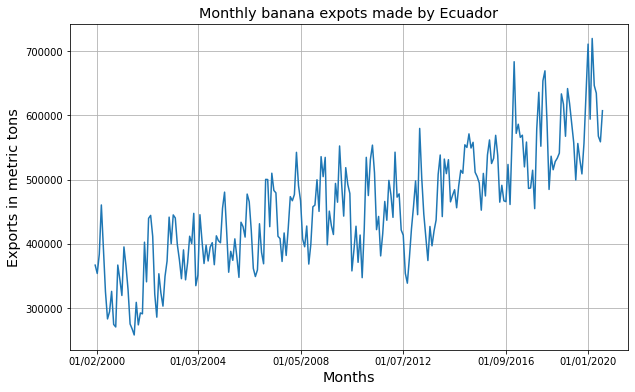

In [4]:
# Cargar dataset
df = pd.read_csv('datosn.csv',  header=0, index_col=0)
print(df.head(5))

# Grafico de los datos
plt.figure(figsize=(10,6)) 
plt.plot(df['Exportaciones'])
plt.grid() 
plt.xticks([1, 50, 100, 150, 200, 240])
plt.ylabel('Exports in metric tons', fontsize='x-large') 
plt.xlabel('Months', fontsize='x-large') 
plt.title('Monthly banana expots made by Ecuador', fontsize='x-large') 
plt.savefig("time_series.png",  pad_inches=0.1, bbox_inches='tight')
plt.show()


In [5]:
# Cargar dataset
values = df.values
print(values.shape)

(248, 1)


In [6]:
# Normalizar features
scaler = MinMaxScaler(feature_range=(0, 1))
values = values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)

In [7]:
# Reframe as supervised learning
window_size=24
reframed = series_to_supervised(scaled, window_size, 1)
print(reframed)
print(reframed.shape)

     var1(t-24)  var1(t-23)  var1(t-22)  ...  var1(t-2)  var1(t-1)   var1(t)
24     0.235559    0.207480    0.272614  ...   0.074284   0.071295  0.312972
25     0.207480    0.272614    0.438503  ...   0.071295   0.312972  0.179234
26     0.272614    0.438503    0.291340  ...   0.312972   0.179234  0.393332
27     0.438503    0.291340    0.145945  ...   0.179234   0.393332  0.403283
28     0.291340    0.145945    0.054178  ...   0.393332   0.403283  0.332901
..          ...         ...         ...  ...        ...        ...       ...
243    0.890855    0.718235    0.490815  ...   0.727801   1.000000  0.841460
244    0.718235    0.490815    0.602858  ...   1.000000   0.841460  0.815620
245    0.490815    0.602858    0.557277  ...   0.841460   0.815620  0.670512
246    0.602858    0.557277    0.584860  ...   0.815620   0.670512  0.651441
247    0.557277    0.584860    0.596212  ...   0.670512   0.651441  0.756457

[224 rows x 25 columns]
(224, 25)


In [8]:
# Split into train, validation and test sets
values = reframed.values
n_train_month = reframed.shape[0] - (12*4) 
train = values[:n_train_month-12, :] # [inidice fila: indice fila , indice col: indice col
valid = values[n_train_month-12:n_train_month, :] 
test = values[n_train_month:, :]
print(train.shape, valid.shape, test.shape)

(164, 25) (12, 25) (48, 25)


In [9]:
# split into input and target
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = valid[:, :-1], valid[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
print('Example of input:\n', x_val[1])
print('Example of target:\n',y_val[1])

Example of input:
 [0.35098415 0.38779449 0.54141282 0.60695506 0.3992384  0.59331524
 0.54416005 0.5912347  0.44903928 0.47076948 0.48987416 0.42899398
 0.50243668 0.55549785 0.54527575 0.64140833 0.63252892 0.67825536
 0.63058271 0.64977009 0.54872808 0.53404264 0.51273966 0.42088176]
Example of target:
 0.5449074618349049


In [10]:
# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1],1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1],1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1],1))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(164, 24, 1) (164,) (12, 24, 1) (12,) (48, 24, 1) (48,)


In [11]:
# RMSE metric 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [12]:
# Define deep neural network model
def DNNmodel():
    input = Input(shape=(window_size, 1), name='Input')
    # LSTM model
    ml1 = Dense(HIDDEN_NEURONS , name='ML_1', activation = 'relu')(input)
    drop1 = Dropout(0.1)(ml1)
    ml2 = Dense(HIDDEN_NEURONS , name='ML_2', activation = 'relu')(drop1)
    flatten_1 = Flatten()(ml2)
    # CNN model
    cnn1D = Conv1D(name = 'Conv1D_1',filters=4, kernel_size=7, strides=1, activation='relu', padding="same")(input) 
    mxPl1D = MaxPooling1D(pool_size=2)(cnn1D)
    flatten_2 = Flatten()(mxPl1D)
    drop2 = Dropout(0.1)(flatten_2)
    # Concatenate models
    concatenated_1 = Concatenate(name='Concatenate_1')([drop2,flatten_1])
    # Output model
    drop3 = Dropout(0.1)(concatenated_1)
    output1 = Dense(OUT_NEURONS, name='output_1')(drop3)
    model = Model(inputs=input, outputs=output1)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = [rmse])
    model.summary()
    return model

In [13]:
# Create the model
EPOCHS = 700
HIDDEN_NEURONS = 7
OUT_NEURONS = 1
model = DNNmodel()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
Conv1D_1 (Conv1D)               (None, 24, 4)        32          Input[0][0]                      
__________________________________________________________________________________________________
ML_1 (Dense)                    (None, 24, 7)        14          Input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 12, 4)        0           Conv1D_1[0][0]                   
______________________________________________________________________________________________

In [14]:
# NModel
history = model.fit(x_train, y_train,validation_data=(x_val,y_val), epochs=EPOCHS, batch_size=32, verbose=1)

Epoch 1/700
6/6 [==============================] - 1s 51ms/step - loss: 0.1296 - rmse: 0.3330 - val_loss: 0.1460 - val_rmse: 0.3740
Epoch 2/700
6/6 [==============================] - 0s 8ms/step - loss: 0.0759 - rmse: 0.2445 - val_loss: 0.0613 - val_rmse: 0.2353
Epoch 3/700
6/6 [==============================] - 0s 6ms/step - loss: 0.0343 - rmse: 0.1516 - val_loss: 0.0148 - val_rmse: 0.1010
Epoch 4/700
6/6 [==============================] - 0s 6ms/step - loss: 0.0189 - rmse: 0.1101 - val_loss: 0.0062 - val_rmse: 0.0647
Epoch 5/700
6/6 [==============================] - 0s 6ms/step - loss: 0.0184 - rmse: 0.1086 - val_loss: 0.0106 - val_rmse: 0.0836
Epoch 6/700
6/6 [==============================] - 0s 6ms/step - loss: 0.0226 - rmse: 0.1247 - val_loss: 0.0083 - val_rmse: 0.0715
Epoch 7/700
6/6 [==============================] - 0s 6ms/step - loss: 0.0160 - rmse: 0.1021 - val_loss: 0.0057 - val_rmse: 0.0633
Epoch 8/700
6/6 [==============================] - 0s 6ms/step - loss: 0.0178 - rm

In [15]:
# Save the model
filepath = "best-model.hdf5"
model.save_weights(filepath)

In [16]:
# Load the model
optimizer = Adam(learning_rate=0.001)
model.load_weights("/content/best-model.hdf5")
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[rmse])

In [17]:
# Evaluate the model
scoretrain = model.evaluate(x_train, y_train, verbose = 0) 
scoreval = model.evaluate(x_val, y_val, verbose = 0) 
scoretest = model.evaluate(x_test, y_test, verbose = 0) 
print('Train loss:', scoretrain[0]) 
print('Train rmse', scoretrain[1])
print('Test loss:', scoretest[0]) 
print('Test rmse:', scoretest[1])
print('Val loss:', scoreval[0]) 
print('Val rmse:', scoreval[1])

Train loss: 0.004212704487144947
Train rmse 0.05165505409240723
Test loss: 0.006475277245044708
Test rmse: 0.06552273780107498
Val loss: 0.002690311288461089
Val rmse: 0.04332088306546211


In [18]:
# Predict test and train
results=model.predict(x_test)
results1=model.predict(x_train)

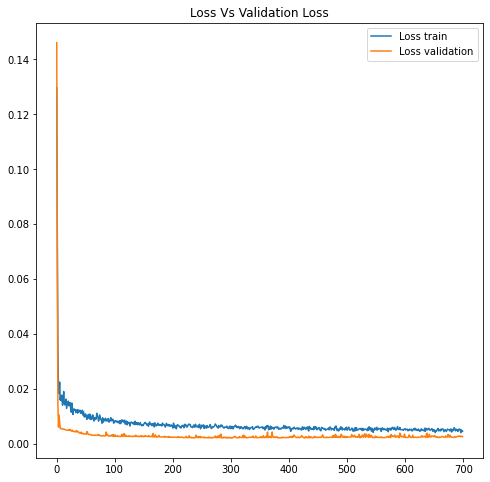

In [19]:
# Plot loss and validation loss
plt.figure(figsize=(8,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss train', 'Loss validation'])
plt.title('Loss Vs Validation Loss')
plt.show()

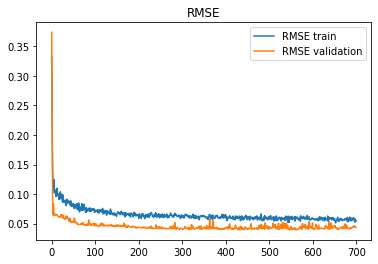

In [20]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('RMSE')
plt.legend(['RMSE train', 'RMSE validation'])
plt.show()

In [21]:
#Save and export
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv('historyCNNLSTM.csv')


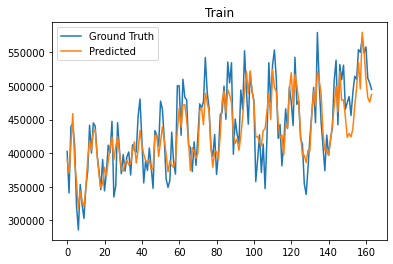

Train Score: 29956.30 RMSE
Train Score: 23840.78 MAE


In [22]:
#Invert and compare values
compara = pd.DataFrame(np.array([y_train, [x[0] for x in results1]])).transpose()
compara.columns = ['Real', 'Prediccion']
inverted = scaler.inverse_transform(compara.values)
realValues = pd.DataFrame(inverted)
realValues.columns = ['Real', 'Prediccion']
realValues.to_csv('entrenamientoCNNLSTM.csv')

plt.plot(realValues['Real'])
plt.plot(realValues['Prediccion'])
plt.legend(['Ground Truth', 'Predicted'])
plt.title('Train')
plt.show()

rmsetrain = math.sqrt(mean_squared_error(realValues['Real'], realValues['Prediccion']))
maetrain = mean_absolute_error(realValues['Real'],realValues['Prediccion'])
print('Train Score: %.2f RMSE' % (rmsetrain))
print('Train Score: %.2f MAE' % (maetrain))

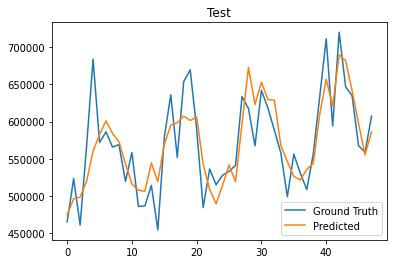

Test Score: 37139.57 RMSE
Test Score: 30241.25 MAE


In [23]:
compara = pd.DataFrame(np.array([y_test, [x[0] for x in results]])).transpose()
compara.columns = ['Real', 'Prediccion']
inverted = scaler.inverse_transform(compara.values)
realValues = pd.DataFrame(inverted)
realValues.columns = ['Real', 'Prediccion']
realValues.to_csv('testCNNLSTM.csv')
realValues['Real'].plot(label = 'Real')
realValues['Prediccion'].plot(label = 'Predicted')
plt.legend(['Ground Truth', 'Predicted'])
plt.title('Test')
plt.show()

rmsetest = math.sqrt(mean_squared_error(realValues['Real'], realValues['Prediccion']))
maetest = mean_absolute_error(realValues['Real'],realValues['Prediccion'])
print('Test Score: %.2f RMSE' % (rmsetest))
print('Test Score: %.2f MAE' % (maetest))